In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
import os
import pandas as pd
import seaborn as sns
cwd = os.getcwd()
parent = os.path.abspath(os.path.join(cwd, os.pardir))
os.chdir(parent)

In [3]:
patient_counts = np.load('out/feature_data/sae_8jsxk3co/custom/hehr/cls_sae_cnt.npy')
with open('configs/classnames/hehr_classnames.txt','r') as file:
    patient_names = [line.strip() for line in file.readlines()]

In [4]:
disease_patient_dict = {
    "AML-CBFB-MYH11": [
        "AQK", "BTB", "FPW", "GOR", "IEN", "MFH", "NCD", "OHZ", "POM", "VDQ", "XIE", "ZRJ",
        "BJK", "DQV", "FKU", "FYX", "HFM", "NXR", "OUR", "SBY", "XBB", "XMA", "ZEE", "ZVS",
        "BSN", "DSN", "ECB", "FOL", "GOP", "HQE", "KOV", "MSC", "OEY", "PCQ", "QCF", "YXH", "ZNB"
    ],
    "AML-NPM1": [
        "ALA", "CVW", "EHM", "FOH", "HXQ", "LBW", "NHB", "OCV", "PBO", "QQD", "RPA", "SDP",
        "TPI", "UVT", "WTE", "YCY", "YRZ", "ZLQ", "ZMX", "BHR", "CZI", "DPF", "IQS", "JTF", "LGB",
        "NPA", "PAM", "QBU", "RFV", "SQF", "SYY", "UXN", "XFF", "YPT", "ZEQ", "ZLW"
    ],
    "AML-PML-RARA": [
        "ALE", "BIK", "GEG", "GQB", "JFC", "JRB", "VAJ", "YST", "BHS", "CMR", "FTW", "GOJ",
        "LYD", "NUS", "OYO", "ZZM"
    ],
    "AML-RUNX1-RUNX1T1": [
        "ABF", "BKR", "DHA", "FQY", "HEJ", "HVE", "ILZ", "KRG", "LPA", "NRB", "ORE", "RGG",
        "RJQ", "SWN", "UGU", "VMO", "XOB", "XXX", "BHG", "BOE", "FED", "GUE", "HMC", "IIG", "ISW",
        "ONF", "RHX", "UWF", "VXU", "XTK", "ZJJ", "ZVX"
    ],
    "SCD": [
        "AEC", "AVL", "CDA", "DHE", "DPU", "FDW", "GJZ", "HQQ", "JGE", "LCW", "MOR", "NFI", "NRL",
        "ORD", "QIZ", "TOK", "UNX", "WOA", "XXI", "YWQ", "ZNL", "AIH", "BXR", "CIQ", "DJJ", "ENH",
        "FUT", "GXQ", "ICS", "KDW", "MJF", "MPP", "NOL", "NVD", "OTU", "RDV", "TVZ", "UOU", "WSD",
        "XXJ", "YXY", "ATM", "CCO", "DFT", "DNX", "FAQ", "GJQ", "HNB", "IPY", "LAM", "MKF", "NAR",
        "NXO", "OVP", "TBZ", "UBG", "VPN", "WXO", "YDL", "ZNK"
    ]
}
reverse_lookup = {}
for disease, patients in disease_patient_dict.items():
    for patient in patients:
        reverse_lookup[patient] = disease

disease_barcode = {}
for disease, patients in disease_patient_dict.items():
    mean_activations = np.zeros(49152, dtype=np.float32)

    count = 0
    for patient in patients:
        try:
            selected_index = patient_names.index(patient)
            patient_data = patient_counts[selected_index]
            mean_activations += patient_data
            count += 1
        except ValueError:
            print(f"Warning: Patient {patient} not found in patient_names. Skipping.")

    if count > 0:
        mean_activations /= count
    else:
        print(f"Warning: No valid patients found for {disease}. Skipping normalization.")

    disease_barcode[disease] = mean_activations

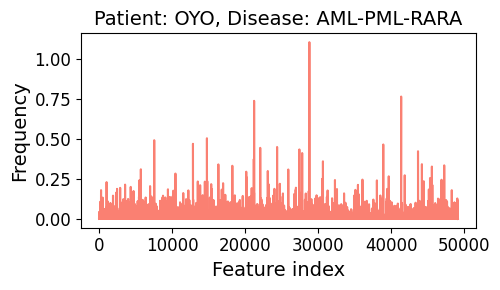

In [5]:
# Print a patient barcode
patient_name = 'OYO'
selected_index = patient_names.index(patient_name)

# Extract the data for the selected patient
patient_data = patient_counts[selected_index]

# Plot the histogram
plt.figure(figsize=(5, 3))
plt.plot(patient_data,color='salmon')
plt.xlabel('Feature index',fontsize=14)
plt.ylabel('Frequency',fontsize=14)
plt.title(f'Patient: {patient_names[selected_index]}, Disease: {reverse_lookup.get(patient_name)}',fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.grid(False)
plt.tight_layout()
plt.show()

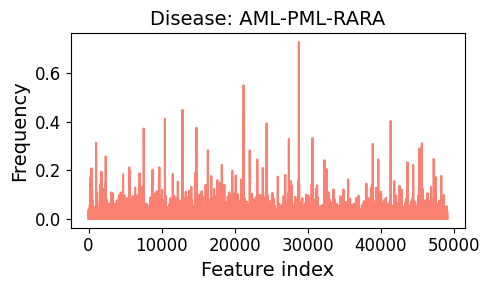

In [6]:
# Print a disease barcode
disease_name1 = 'AML-PML-RARA'
disease_data = disease_barcode[disease_name1]

# Plot the histogram
plt.figure(figsize=(5, 3))
plt.plot(disease_data,color='salmon')
plt.xlabel('Feature index',fontsize=14)
plt.ylabel('Frequency',fontsize=14)
plt.title(f'Disease: {disease_name1}',fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.grid(False)
plt.tight_layout()
plt.show()

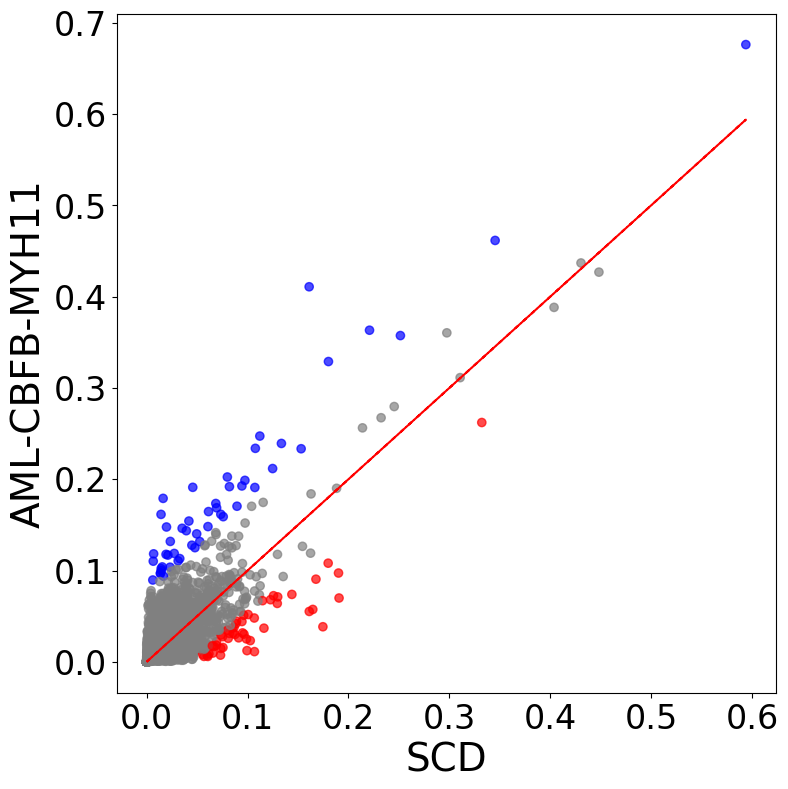

In [9]:
# Compare two disease barcodes and higlight top differences

disease_name1 = 'SCD'
disease_name2 = 'AML-CBFB-MYH11'

# Extract disease activations
disease1 = disease_barcode[disease_name1]
disease2 = disease_barcode[disease_name2]

# Create DataFrame
df = pd.DataFrame({
    disease_name1: disease1, 
    disease_name2: disease2, 
    'index': list(range(len(disease1))) 
})
red_indices = np.argsort((disease1-disease2))[-50:][::-1]  #pmlrara to cbfb
blue_indices = np.argsort((disease2-disease1))[-50:][::-1] #cbfb to pmlrara
colors = ['red' if idx in red_indices else 'gray' for idx in df['index']]
colors = ['blue' if idx in blue_indices else c for idx,c in zip(df['index'],colors)]

scale = 8
# Create scatter plot with Matplotlib
plt.figure(figsize=(scale, scale))
plt.scatter(df[disease_name1], df[disease_name2], label="Data Points", alpha=0.7,color=colors)
plt.plot(df[disease_name1], df[disease_name1], linestyle="--", color="red", label="y = x")

# Labels and title
plt.xlabel(f'{disease_name1}',fontsize=14/4*scale)
plt.ylabel(f'{disease_name2}',fontsize=14/4*scale)
plt.xticks(fontsize=12/4*scale)
plt.yticks(fontsize=12/4*scale)
#plt.xlim((0,72))
#plt.ylim((0,72))
plt.tight_layout()
plt.show()

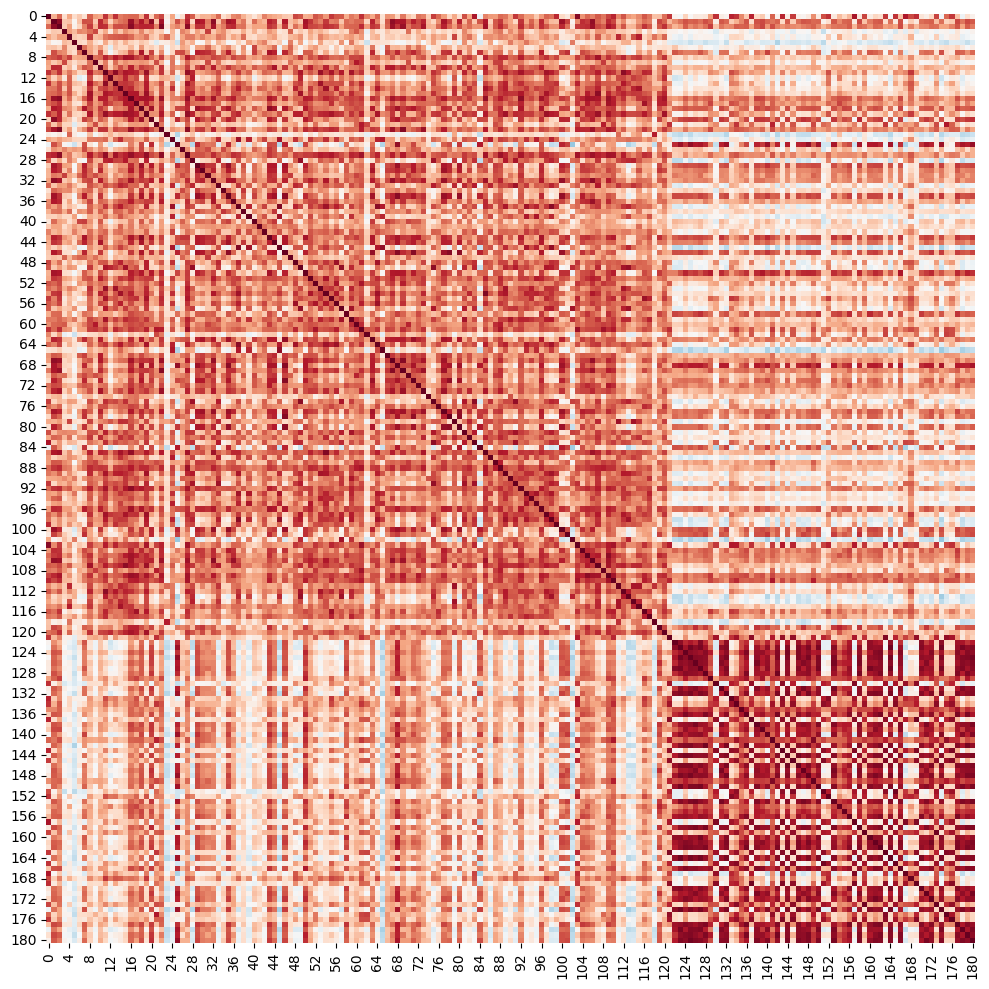

In [8]:
ordered_patient_names = []
for disease, patients in disease_patient_dict.items():
    ordered_patient_names.extend(patients)

# Map patient names to indices
patient_indices = {name: idx for idx, name in enumerate(patient_names)}

# Reorder data matrix based on disease order
ordered_indices = [patient_indices[name] for name in ordered_patient_names if name in patient_indices]
reordered_cls_count = patient_counts[ordered_indices]
reordered_correlation_matrix = np.corrcoef(reordered_cls_count)
# Generate heatmap
plt.figure(figsize=(10, 10))
sns.heatmap(reordered_correlation_matrix, cmap="RdBu_r", center=0.5, annot=False, cbar=False)
plt.tight_layout()
plt.show()